# LyLimit

##### This notebook replicates Figure 5 and Figure 6 from the specwizard paper.

We start by importing all the libraries that we will need. Specially the SpecWizard_Lines routine.

In [1]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import copy 
import sys
sys.path.append('../../')
import Phys
constants = Phys.ReadPhys()
from SpecWizard_Lines import Lines


7999.200000000001 1 1e+17
6499.35 50 3.1622776601683795e+17


/tmp/ipykernel_2361967/3969232039.py:78: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


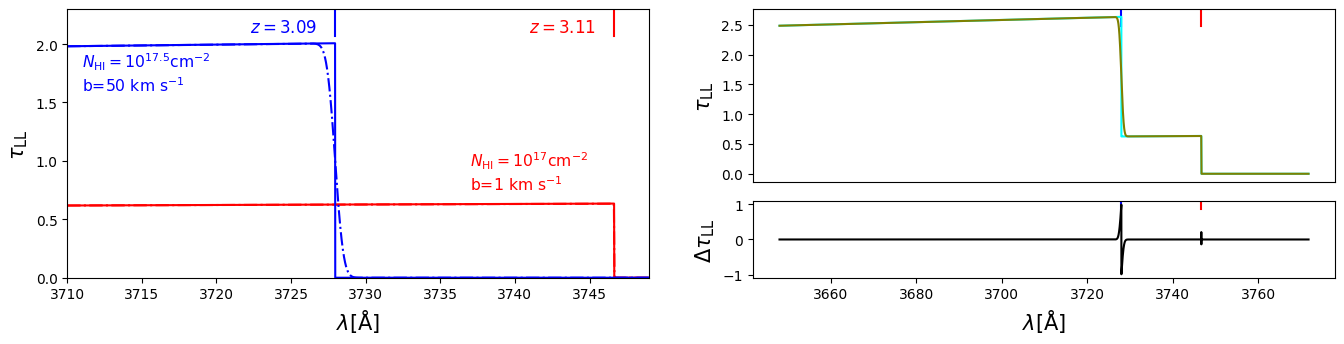

In [12]:
def gauss(v0_kms,b_kms,Nh1,vel_kms):
    sigma_alpha = np.sqrt(3*np.pi*constants["sigmaT"]/8.) * f_value * lambda0 * (constants["c"]) 
    norm        = 1/np.sqrt(b_kms**2*np.pi) / 1e5
    return sigma_alpha*Nh1 * norm * np.exp(-(vel_kms-v0_kms)**2/b_kms**2)


ll_systems = {}
ll_systems['Nh']      =  10**(np.array([17.0,17.5]))
ll_systems['v0_ipix'] =  [0.8,0.65]
ll_systems['b_kms']   =  [1,50]
lambda0    = 1215.67e-8      # Lya wavelength [cm]
f_value    = 0.4164  
pixkms    = 1 
npix      = 10000
tau_alpha = np.zeros(npix,dtype=float)
tau_alpha_tot = np.zeros(npix,dtype=float)
tau_ll_tot = np.zeros(npix,dtype=float)
tau_ll    = np.zeros_like(tau_alpha)
vel_kms   = np.arange(npix) * pixkms
z         = 3.
c_kms     = constants['c'] / 1e5
colours   = ['r','b','olive'] 
vw_aff      = 912.* (1+z) * np.exp(vel_kms/c_kms) 
fontsize  = 15 

lines = Lines(v_kms= vel_kms,naturalwidth_kms=6.06076e-3)

fig = plt.figure(constrained_layout=True,figsize=(40/3, 10/3))
gs = fig.add_gridspec(6, 6,hspace=0,wspace=0.2)

ax1 = fig.add_subplot(gs[:, :3])
ax2 = fig.add_subplot(gs[:4, 3:])
ax3 = fig.add_subplot(gs[4:, 3:])
zas  = ['3.11','3.09']
for i,(nh,ipix,b_kms,colour,za) in enumerate(zip(ll_systems['Nh'],ll_systems['v0_ipix'],ll_systems['b_kms'],colours,zas)):
     
    v0_kms          = ipix*vel_kms[-1]
    vw0_aff      = 912.* (1+z) * np.exp(v0_kms/c_kms) 

    print(v0_kms,b_kms,nh)
    tau_alpha  = gauss(v0_kms,b_kms,nh,vel_kms)
    tau_alpha_tot += tau_alpha
    hnu        =13.6 * np.exp(-(vel_kms-v0_kms)/c_kms)
    tau_ll     = nh *  lines.sigmaHI(hnu)
    tau_ll_tot  += tau_ll

    tau_ll_conv   = lines.convolveLymanLimit(tau_alpha)
    ax1.plot(vw_aff,tau_ll,color=colour)
    ax1.plot(vw_aff,tau_ll_conv,c=colour,linestyle='dashdot')
    ax1.axvline(x=vw0_aff,ymin=0.9,ymax=1,color=colour)
    ax2.axvline(x=vw0_aff,ymin=0.9,ymax=1,color=colour)
    ax3.axvline(x=vw0_aff,ymin=0.9,ymax=1,color=colour)
    
    ax1.text(vw_aff[int(npix*ipix)]-5.7 , 2.1 ,r'$z=$'+za, fontsize=fontsize*0.8,color=colour)
    

ax1.set_ylim(0,2.3)
ax1.set_xlim(3710,3749)
ax1.set_xlabel(r'$\lambda \mathrm{[\AA]}$',fontsize=fontsize )
ax1.set_ylabel(r'$\tau_\mathrm{LL}$',fontsize=fontsize )
ax1.text(3737, 0.95 ,r'$N_\mathrm{HI}=10^{17} \mathrm{cm^{-2}}$', fontsize=fontsize*0.75,color='red')
ax1.text(3737, 0.75 ,r'b=$1~\mathrm{ km~s^{-1}}$', fontsize=fontsize*0.75,color='red')

ax1.text(3711, 1.8 ,r'$N_\mathrm{HI}=10^{17.5} \mathrm{cm^{-2}}$', fontsize=fontsize*0.75,color='b')
ax1.text(3711, 1.6 ,r'b=$50~\mathrm{ km~s^{-1}}$', fontsize=fontsize*0.75,color='b')

tau_ll_conv   = lines.convolveLymanLimit(tau_alpha_tot)

ax2.plot(vw_aff,tau_ll_tot,c='cyan')
ax2.tick_params(labelbottom=False)
ax2.set_xticks([])
ax2.plot(vw_aff,tau_ll_conv,c='olive')
ax2.set_ylabel(r'$ \tau_\mathrm{LL}$',fontsize=fontsize )

ax3.plot(vw_aff,tau_ll_tot-tau_ll_conv,c='k')
ax3.set_xlabel(r'$\lambda \mathrm{[\AA]}$',fontsize=fontsize )
ax3.set_ylabel(r'$\Delta \tau_\mathrm{LL}$',fontsize=fontsize )
fig.subplots_adjust(hspace=0)

plt.savefig("llsystems.png",bbox_inches='tight',dpi=300)

In [5]:
def SciPyVoigt( b_kms=10., v0_kms=0.0,vel_kms=vel_kms):
    from scipy.special import voigt_profile as VoigtSciPy
    ''' 
    return Voigt line-profile function, Equation 5
    this version uses the SciPy implementation of the Voigt function
    input:
         b_kms (float):     b-parameter [km/s]
         v0_kms (float):    velocity at line centre [km/s]
    output: 
         line profile (float or array) : line shap with unit column density [s/cm]

    '''
    lines = Lines(v_kms= vel_kms,naturalwidth_kms=6.06076e-3)
    u           = lines.PeriodicVelocity(v0_kms=v0_kms) / b_kms
    # 
    sigma_G     = 1.0 / np.sqrt(2.0)                # variance of Gaussian
    gamma_L     = lines.naturalwidth / b_kms         # Half-width half-maximum of Lorenzian - the parameter "a"
    # evaluate Voigt profile
    vnorm       = VoigtSciPy(u, sigma_G, gamma_L, out=None)
    phi         = vnorm / b_kms                     # SciPy returns a normalize Voigt profile, which includes the 1/sqrt(pi)
    return phi/1e5  # convert to units of [s/cm]

7999.200000000001 10 3.162277660168379e+19
4999.5 20.01 1.995262314968883e+20


/tmp/ipykernel_2361967/260720492.py:68: RuntimeWarning: divide by zero encountered in log10
  ax[1].plot(vw_aff,np.log10(tau_alpha),c='blue',linestyle='dashed')


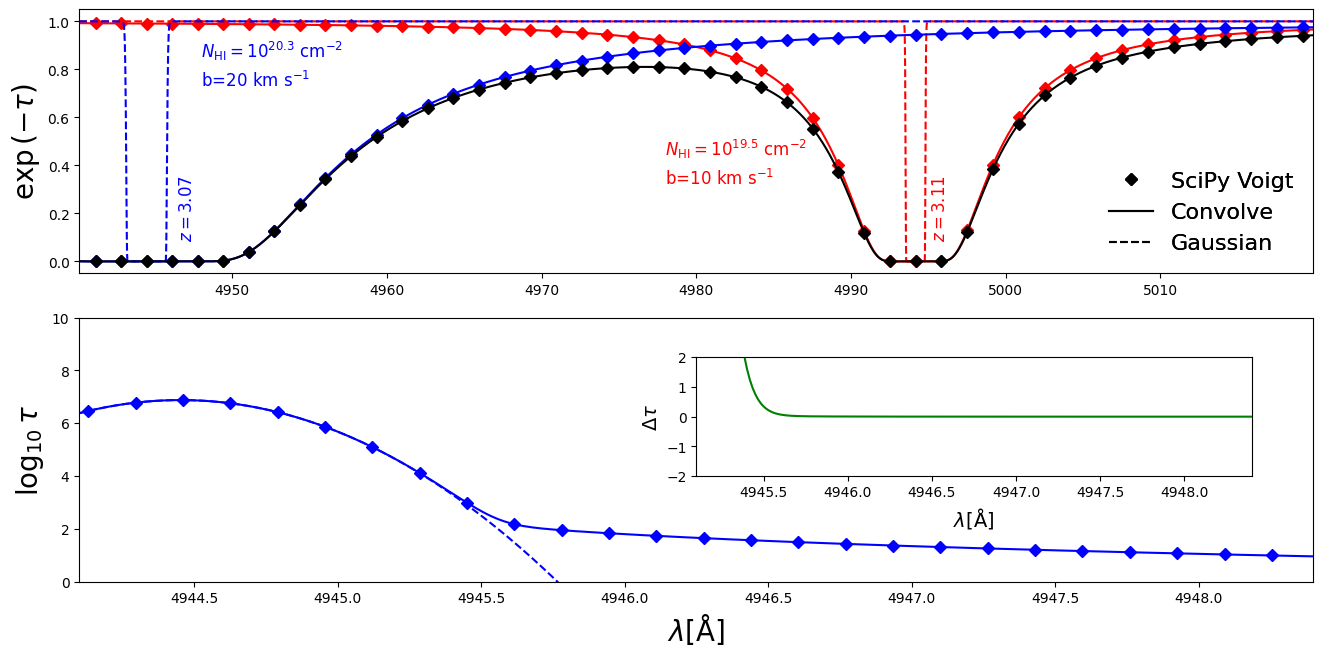

In [18]:
ll_systems = {}
ll_systems['Nh']      =  10**(np.array([19.5,20.3]))
ll_systems['v0_ipix'] =  [0.8,0.5]
ll_systems['b_kms']   =  [10,20.01]
npix = 10000


pixkms    = 1.0 
npix      = 10000
tau_alpha = np.zeros(npix,dtype=float)
tau_ll    = np.zeros_like(tau_alpha)
vel_kms   = np.arange(npix) * pixkms
c_kms     = constants['c'] / 1e5


tau_alpha_tot = np.zeros(npix,dtype=float)
tau_scivoigt_tot = np.zeros_like(tau_alpha_tot)
vel_kms   = np.arange(npix) * pixkms
c_kms     = constants['c'] / 1e5

#fig, ax   = plt.subplots(1, 2, figsize = (20, 7))
colours   = ['r','b','olive'] 
vw_aff      = 1215.67* (1+3.) * np.exp(vel_kms/c_kms) 
fontsize  = 20 
lines_short = Lines(v_kms= vel_kms,naturalwidth_kms=6.06076e-3,box_kms=vel_kms.max())
fontsize  = 20 
center_indx = int(npix/2)

fig, ax = plt.subplots(2,1,figsize=(40/3,20/3))
handles = []
zas = ['3.11','3.07']
for i,(nh,ipix,b_kms,colour,za) in enumerate(zip(ll_systems['Nh'],ll_systems['v0_ipix'],ll_systems['b_kms'],colours,zas)):
     
    v0_kms          = ipix*vel_kms[-1]
    vw0_aff      = 1215.67* (1+3.) * np.exp(v0_kms/c_kms) 
    print(v0_kms,b_kms,nh)
    tau_alpha  = gauss(v0_kms,b_kms,nh,vel_kms)
    voigt_short = lines_short.convolvelorentz(tau_alpha)    
    
    a,b = lines_short.SciPyVoigt(b_kms=b_kms,v0_kms=v0_kms,periodic=False)
    
    la  = 1215.67* (1+3.) * np.exp(a/c_kms) 
    tau_scivoigt     = lines_short.sigma *nh*b
     
    tau_scivoigt_vw_aff = np.interp(vw_aff, la, tau_scivoigt)
    tau_scivoigt_tot += tau_scivoigt_vw_aff
    tau_alpha_tot += tau_alpha
    
    #ax[0].plot(la,np.exp(-tau_scivoigt),label='SciPy Voigt')
    if i ==0:
        h, =  ax[0].plot(vw_aff[::100],np.exp(-tau_scivoigt_vw_aff[::100]),'D',c=colour,label='SciPy Voigt')
        handles.append(copy.copy(h))
        h, =   ax[0].plot(vw_aff,np.exp(-voigt_short),c=colour,label='Convolve')
        handles.append(copy.copy(h))
        h, =    ax[0].plot(vw_aff,np.exp(-tau_alpha),c=colour,label='Gaussian',linestyle='dashed')
        handles.append(copy.copy(h))

    else:
        ax[0].plot(vw_aff[::100],np.exp(-tau_scivoigt_vw_aff[::100]),'D',c=colour)
        
        ax[0].plot(vw_aff,np.exp(-voigt_short),c=colour)
        
        ax[0].plot(vw_aff,np.exp(-tau_alpha),c=colour,label='gauss',linestyle='dashed')
   # ax[0].set_xlim(vw_aff[center_indx]-5,vw_aff[center_indx]+80)
   # ax[0].set_ylim(0,1)
    if i ==1:
        ax[1].plot(vw_aff,np.log10(voigt_short),c='blue')
        ax[1].plot(vw_aff,np.log10(tau_alpha),c='blue',linestyle='dashed')

        #ax[1].plot(vw_aff,np.log10(tau_scivoigt_vw_aff),c='b')
        ax[1].plot(la[::10],np.log10(tau_scivoigt[::10]),'D',c='b')

        ins = ax[1].inset_axes([0.5,0.4,0.45,0.45])
        ins.plot(vw_aff,voigt_short-tau_scivoigt_vw_aff, color='green')
        ins.set_xlim(4945,4958)
        ins.set_xlim(4945.1,4948.4)
        ins.set_ylim(-2,2)
        #ax[1].set_xlim(4850,5050)
        ax[1].set_xlim(vw_aff[center_indx]-0.25,vw_aff[center_indx]+4)
        ax[1].set_ylim(0,10)
    voff = 2
    if i == 0:
        voff = 1
    
    ax[0].text(vw_aff[int(npix*ipix)]+voff , 0.1 ,r'$z=$'+za, fontsize=fontsize*0.6,color=colour,rotation='vertical')
    
for h in handles:
    h.set_color('k')
    
legend1 = ax[0].legend(handles=handles,
                loc="lower right",fontsize=fontsize*0.8,frameon=False)




ax[0].text(4978, 0.44 ,r'$N_\mathrm{HI}=10^{19.5}~\mathrm{cm^{-2}}$', fontsize=fontsize*0.6,color='red')
ax[0].text(4978, 0.32 ,r'b=$10~\mathrm{ km~s^{-1}}$', fontsize=fontsize*0.6,color='red')

ax[0].text(4948, 0.85 ,r'$N_\mathrm{HI}=10^{20.3}~\mathrm{cm^{-2}}$', fontsize=fontsize*0.6,color='b')
ax[0].text(4948, 0.73 ,r'b=$20~\mathrm{ km~s^{-1}}$', fontsize=fontsize*0.6,color='b')

ax[0].set_xlim(4940.1,5019.9)
ax[1].set_xlim(4944.1,4948.4)
ax[0].add_artist(legend1)
voigt_short = lines_short.convolvelorentz(tau_alpha_tot)    
handles2 = []
ax[0].set_ylabel(r'$\exp{(-\tau)}$',fontsize=fontsize )
ax[1].set_xlabel(r'$\lambda \mathrm{[\AA]}$',fontsize=fontsize )
ax[1].set_ylabel(r'$\log_{10} \tau$',fontsize=fontsize )

ins.set_xlabel(r'$\lambda \mathrm{[\AA]}$',fontsize=fontsize*0.7 )
ins.set_ylabel(r'$\Delta \tau$',fontsize=fontsize *0.7)

h, = ax[0].plot(vw_aff,np.exp(-voigt_short),c='k')
handles2.append(copy.copy(h))
h, = ax[0].plot(vw_aff[::100],np.exp(-tau_scivoigt_tot[::100]),'D',c='k')
handles2.append(copy.copy(h))
fig.tight_layout()
plt.savefig("DLA.png",bbox_inches='tight',dpi=300)